# CSE-144 - 2025 Winter - Final-Project

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import timm
from torchvision.models import resnet50, ResNet50_Weights
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR

# 1. Reproducibility Settings

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 2. Device Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# 3. Model Type & Image Size

In [4]:
model_type = "resnet50"
# model_type = "swin_v2"
# model_type = "vit"

if model_type == "resnet50":
    image_size = 224
elif model_type == "swin_v2":
    image_size = 256
elif model_type == "vit":
    image_size = 518

# 4. Directories & Numeric Label Mapping

In [5]:
train_dir = "train"
test_dir = "test"

def numerical_sort_key(folder_name: str):
    return int(folder_name)

folder_names = sorted(
    [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))],
    key=numerical_sort_key
)
class_to_idx = {name: int(name) for name in folder_names}

base_dataset = datasets.ImageFolder(root=train_dir, transform=None)
base_dataset.class_to_idx = class_to_idx
base_dataset.samples = [
    (path, class_to_idx[os.path.basename(os.path.dirname(path))])
    for (path, _) in base_dataset.samples
]

print("Custom numeric ordering (class_to_idx):", base_dataset.class_to_idx)
print("Number of total samples:", len(base_dataset))

Custom numeric ordering (class_to_idx): {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42, '43': 43, '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '50': 50, '51': 51, '52': 52, '53': 53, '54': 54, '55': 55, '56': 56, '57': 57, '58': 58, '59': 59, '60': 60, '61': 61, '62': 62, '63': 63, '64': 64, '65': 65, '66': 66, '67': 67, '68': 68, '69': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '80': 80, '81': 81, '82': 82, '83': 83, '84': 84, '85': 85, '86': 86, '87': 87, '88': 88, '89': 89, '90': 90, '91': 91, '92': 92, '93': 93, '94': 94, '95': 95, '96': 96, '97': 97,

# 5. Augmentation Transforms

In [6]:
class AugMix:
    def __init__(self, severity=1):
        self.severity = severity
        self.augmentations = [
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomRotation(15),
            transforms.RandomHorizontalFlip(),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
        ]
    
    def __call__(self, img):
        if random.random() < 0.5:
            aug = random.choice(self.augmentations)
            return aug(img)
        return img

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    AugMix(),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 6. Train/Validation Split

In [7]:
val_ratio = 0.2
n_total = len(base_dataset)
n_val = int(val_ratio * n_total)
n_train = n_total - n_val
train_subset, val_subset = random_split(base_dataset, [n_train, n_val])

class TransformWrapper(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        pil_img, label = self.subset[idx]
        if self.transform:
            pil_img = self.transform(pil_img)
        return pil_img, label

train_dataset = TransformWrapper(train_subset, transform=train_transforms)
val_dataset   = TransformWrapper(val_subset,   transform=val_transforms)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

Train samples: 800, Val samples: 200


# 7. Model Creation

In [8]:
def create_model(model_type="resnet50", num_classes=100, dropout_p=0.5):
    if model_type == "resnet50":
        model = resnet50(weights=ResNet50_Weights.DEFAULT)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_features, num_classes)
        )
    elif model_type == "swin_v2":
        model = timm.create_model("swinv2_base_window8_256", pretrained=True)
        in_features = model.head.in_features
        model.head = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_features, num_classes)
        )
    elif model_type == "vit":
        model = timm.create_model("vit_base_patch16_224", pretrained=True)
        in_features = model.head.in_features
        model.head = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_features, num_classes)
        )
    return model.to(device)

model = create_model(model_type=model_type, num_classes=100, dropout_p=0.5)

# 8. Unfreeze More Layers

In [9]:
for param in model.parameters():
    param.requires_grad = True

# 9. MixUp Function

In [10]:
def mixup_data(x, y, alpha=0.1):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 10. Training Setup

In [11]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 50
early_stop_patience = 10
best_val_loss = float('inf')
no_improve_epochs = 0

train_losses, val_losses = [], []
train_acc_history, val_acc_history = [], []

# Mixed precision scaler
scaler = GradScaler()

# OneCycleLR: total_steps = num_epochs * steps_per_epoch
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(
    optimizer, 
    max_lr=1e-3,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    pct_start=0.2
)

print("\nStarting Training Loop")
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # MixUp
        images_mix, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.1)
        
        # Forward pass with mixed precision
        with autocast():
            outputs = model(images_mix)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Step the scheduler each batch for OneCycleLR
        scheduler.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    avg_val_loss = val_loss / total_val
    val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}; "
          f"Val Loss {avg_val_loss:.4f}, Val Acc {val_acc:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved!")
    else:
        no_improve_epochs += 1
        print(f"No improvement for {no_improve_epochs} epoch(s).")
        if no_improve_epochs >= early_stop_patience:
            print("Early stopping triggered.")
            break

/tmp/ipykernel_4302/2612028022.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Starting Training Loop


/tmp/ipykernel_4302/2612028022.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.01it/s]
/tmp/ipykernel_4302/2612028022.py:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50, Train Loss 4.6002, Train Acc 0.0112; Val Loss 4.5627, Val Acc 0.0100
Best model saved!


Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.64it/s]


Epoch 2/50, Train Loss 4.4475, Train Acc 0.0400; Val Loss 4.3416, Val Acc 0.0700
Best model saved!


Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.00it/s]


Epoch 3/50, Train Loss 3.9186, Train Acc 0.0900; Val Loss 3.5691, Val Acc 0.1600
Best model saved!


Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.40it/s]


Epoch 4/50, Train Loss 3.2647, Train Acc 0.1575; Val Loss 3.4325, Val Acc 0.2150
Best model saved!


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.07it/s]


Epoch 5/50, Train Loss 2.9263, Train Acc 0.1750; Val Loss 3.1938, Val Acc 0.2350
Best model saved!


Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.10it/s]


Epoch 6/50, Train Loss 2.6216, Train Acc 0.2825; Val Loss 3.1829, Val Acc 0.2550
Best model saved!


Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.13it/s]


Epoch 7/50, Train Loss 2.5764, Train Acc 0.1837; Val Loss 3.4433, Val Acc 0.1700
No improvement for 1 epoch(s).


Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.08it/s]


Epoch 8/50, Train Loss 2.4974, Train Acc 0.2238; Val Loss 3.0786, Val Acc 0.2950
Best model saved!


Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.05it/s]


Epoch 9/50, Train Loss 2.4183, Train Acc 0.2425; Val Loss 3.9271, Val Acc 0.2100
No improvement for 1 epoch(s).


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.12it/s]


Epoch 10/50, Train Loss 2.2377, Train Acc 0.3538; Val Loss 3.5417, Val Acc 0.2500
No improvement for 2 epoch(s).


Epoch 11/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.97it/s]


Epoch 11/50, Train Loss 2.0235, Train Acc 0.4437; Val Loss 3.0787, Val Acc 0.3550
No improvement for 3 epoch(s).


Epoch 12/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.01it/s]


Epoch 12/50, Train Loss 1.9261, Train Acc 0.4163; Val Loss 2.9337, Val Acc 0.3700
Best model saved!


Epoch 13/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.08it/s]


Epoch 13/50, Train Loss 1.7629, Train Acc 0.3812; Val Loss 3.1293, Val Acc 0.3850
No improvement for 1 epoch(s).


Epoch 14/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.92it/s]


Epoch 14/50, Train Loss 1.6274, Train Acc 0.4838; Val Loss 2.9374, Val Acc 0.3800
No improvement for 2 epoch(s).


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.81it/s]


Epoch 15/50, Train Loss 1.6582, Train Acc 0.4188; Val Loss 2.9871, Val Acc 0.3700
No improvement for 3 epoch(s).


Epoch 16/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.92it/s]


Epoch 16/50, Train Loss 1.4150, Train Acc 0.5750; Val Loss 3.0159, Val Acc 0.3700
No improvement for 4 epoch(s).


Epoch 17/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.01it/s]


Epoch 17/50, Train Loss 1.3361, Train Acc 0.4350; Val Loss 2.8022, Val Acc 0.4050
Best model saved!


Epoch 18/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.80it/s]


Epoch 18/50, Train Loss 1.4208, Train Acc 0.4850; Val Loss 3.0110, Val Acc 0.3700
No improvement for 1 epoch(s).


Epoch 19/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.01it/s]


Epoch 19/50, Train Loss 1.3516, Train Acc 0.5250; Val Loss 2.7883, Val Acc 0.4100
Best model saved!


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.05it/s]


Epoch 20/50, Train Loss 1.3963, Train Acc 0.5050; Val Loss 2.7374, Val Acc 0.4100
Best model saved!


Epoch 21/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.99it/s]


Epoch 21/50, Train Loss 1.3769, Train Acc 0.4387; Val Loss 2.7719, Val Acc 0.3900
No improvement for 1 epoch(s).


Epoch 22/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.00it/s]


Epoch 22/50, Train Loss 1.2403, Train Acc 0.5000; Val Loss 2.6803, Val Acc 0.4400
Best model saved!


Epoch 23/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.41it/s]


Epoch 23/50, Train Loss 1.2992, Train Acc 0.5400; Val Loss 2.6808, Val Acc 0.4350
No improvement for 1 epoch(s).


Epoch 24/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.03it/s]


Epoch 24/50, Train Loss 1.1975, Train Acc 0.6150; Val Loss 2.7966, Val Acc 0.3900
No improvement for 2 epoch(s).


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.96it/s]


Epoch 25/50, Train Loss 1.3576, Train Acc 0.5088; Val Loss 2.7735, Val Acc 0.4200
No improvement for 3 epoch(s).


Epoch 26/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.55it/s]


Epoch 26/50, Train Loss 1.3408, Train Acc 0.4300; Val Loss 2.7341, Val Acc 0.4100
No improvement for 4 epoch(s).


Epoch 27/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.99it/s]


Epoch 27/50, Train Loss 1.3142, Train Acc 0.5487; Val Loss 2.7127, Val Acc 0.4200
No improvement for 5 epoch(s).


Epoch 28/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.99it/s]


Epoch 28/50, Train Loss 1.0789, Train Acc 0.5863; Val Loss 2.6581, Val Acc 0.4400
Best model saved!


Epoch 29/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.99it/s]


Epoch 29/50, Train Loss 1.1509, Train Acc 0.5312; Val Loss 2.6193, Val Acc 0.4350
Best model saved!


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.88it/s]


Epoch 30/50, Train Loss 1.1985, Train Acc 0.5363; Val Loss 2.5873, Val Acc 0.4650
Best model saved!


Epoch 31/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.02it/s]


Epoch 31/50, Train Loss 1.3666, Train Acc 0.5062; Val Loss 2.6734, Val Acc 0.4500
No improvement for 1 epoch(s).


Epoch 32/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.97it/s]


Epoch 32/50, Train Loss 1.3395, Train Acc 0.5350; Val Loss 2.6646, Val Acc 0.4300
No improvement for 2 epoch(s).


Epoch 33/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.02it/s]


Epoch 33/50, Train Loss 1.3029, Train Acc 0.6125; Val Loss 2.5993, Val Acc 0.4600
No improvement for 3 epoch(s).


Epoch 34/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.94it/s]


Epoch 34/50, Train Loss 1.1997, Train Acc 0.5850; Val Loss 2.5275, Val Acc 0.4600
Best model saved!


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.70it/s]


Epoch 35/50, Train Loss 1.3195, Train Acc 0.5837; Val Loss 2.5650, Val Acc 0.4550
No improvement for 1 epoch(s).


Epoch 36/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.00it/s]


Epoch 36/50, Train Loss 1.0921, Train Acc 0.4213; Val Loss 2.5285, Val Acc 0.4800
No improvement for 2 epoch(s).


Epoch 37/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.93it/s]


Epoch 37/50, Train Loss 1.1942, Train Acc 0.6450; Val Loss 2.4893, Val Acc 0.4850
Best model saved!


Epoch 38/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.68it/s]


Epoch 38/50, Train Loss 1.1499, Train Acc 0.5175; Val Loss 2.5387, Val Acc 0.4800
No improvement for 1 epoch(s).


Epoch 39/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.94it/s]


Epoch 39/50, Train Loss 1.0451, Train Acc 0.5900; Val Loss 2.4855, Val Acc 0.4900
Best model saved!


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.91it/s]


Epoch 40/50, Train Loss 1.2078, Train Acc 0.5450; Val Loss 2.5112, Val Acc 0.4800
No improvement for 1 epoch(s).


Epoch 41/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.54it/s]


Epoch 41/50, Train Loss 1.1535, Train Acc 0.6700; Val Loss 2.5226, Val Acc 0.5000
No improvement for 2 epoch(s).


Epoch 42/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.84it/s]


Epoch 42/50, Train Loss 1.1244, Train Acc 0.5250; Val Loss 2.5120, Val Acc 0.4950
No improvement for 3 epoch(s).


Epoch 43/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.73it/s]


Epoch 43/50, Train Loss 1.2001, Train Acc 0.4938; Val Loss 2.4844, Val Acc 0.4950
Best model saved!


Epoch 44/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.05it/s]


Epoch 44/50, Train Loss 1.1925, Train Acc 0.4788; Val Loss 2.4960, Val Acc 0.4900
No improvement for 1 epoch(s).


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.95it/s]


Epoch 45/50, Train Loss 1.2563, Train Acc 0.5088; Val Loss 2.5092, Val Acc 0.4950
No improvement for 2 epoch(s).


Epoch 46/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.44it/s]


Epoch 46/50, Train Loss 1.1999, Train Acc 0.5425; Val Loss 2.5063, Val Acc 0.4800
No improvement for 3 epoch(s).


Epoch 47/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.18it/s]


Epoch 47/50, Train Loss 1.2157, Train Acc 0.5450; Val Loss 2.4784, Val Acc 0.4950
Best model saved!


Epoch 48/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.11it/s]


Epoch 48/50, Train Loss 1.2001, Train Acc 0.5212; Val Loss 2.4814, Val Acc 0.4850
No improvement for 1 epoch(s).


Epoch 49/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.06it/s]


Epoch 49/50, Train Loss 1.1302, Train Acc 0.4725; Val Loss 2.4881, Val Acc 0.4950
No improvement for 2 epoch(s).


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.12it/s]


Epoch 50/50, Train Loss 1.1765, Train Acc 0.4012; Val Loss 2.4921, Val Acc 0.4950
No improvement for 3 epoch(s).


# 11. Plot Loss Curves

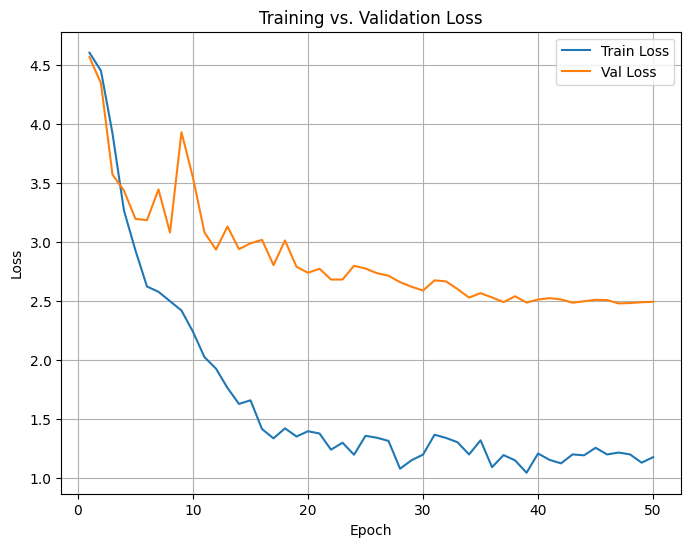

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 12. Testing and Submission

In [13]:
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.file_list = sorted(
            [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))],
            key=lambda x: int(os.path.splitext(x)[0])
        )
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        path = os.path.join(self.test_dir, file_name)
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, file_name

test_dataset = TestDataset(test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

predictions = []
with torch.no_grad(), autocast():
    for images, file_names in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for fn, label_idx in zip(file_names, preds.cpu().numpy()):
            predictions.append({"ID": fn, "Label": int(label_idx)})

submission_df = pd.DataFrame(predictions)
submission_df["numeric_id"] = submission_df["ID"].apply(lambda x: int(os.path.splitext(x)[0]))
submission_df = submission_df.sort_values(by="numeric_id")
submission_df.drop(columns=["numeric_id"], inplace=True)
submission_df.to_csv("submission.csv", index=False)
print("Submission saved: submission.csv")

/tmp/ipykernel_4302/3849362033.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Testing: 100%|████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 38.78it/s]

Submission saved: submission.csv
